# Neural Networks - Deep Learning

## Final Assignment - Multiclass Classification using MLP models
### Dimitrios Tikvinas AEM: 9998

# Introduction

In this assignment we are going to implement multiple MLP models in order to efficiently perform multiclass classification in the well-known and significant in the field of computer vision dataset **CIFAR-10**. It is consisted of 60000 **32x32 colour**(*RGB, meaning 3 color channel*) images  in **10** classes, with **6000 images per class**(*equalized*).

 Because we are dealing with images, we know beforehand that **convolutional neural networks** will probably perform better than the regular ones. Nonetheless, we will not abandon from the start the idea of using the regular neural networks, since the CNN require the use of GPU in order to fruit their advantage.

 It is of paramount importance to identify the strengths and weaknesses of different models used, so that we become able to work towards the ultimate one for our dataset.

 Throughout our project, we will make predictions on the test set ONLY for educational purposes and try to use as our guide only the validation set, since we want to leave the test set unattached and unknown up until the final evaluation of the ultimate model we produce.

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models,layers
from tensorflow.keras import regularizers
from tensorflow.keras import initializers

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

import numpy as np
import time

from matplotlib import pyplot as plt

Testing that GPU is working

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else :
  print('Found GPU at: {}'.format(device_name))

GPU device not found


Because i don't have any in my laptop, i will have to use the CPU to train the CNNs.

## Loading and exploring the CIFAR-10 dataset

In [3]:
# Load the CIFAR-10 dataset (only way found to load them efficiently)
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()


# Store the images and the labels to be left unattached
X_train_un, X_test_un = X_train, X_test
Y_train_un, Y_test_un = Y_train, Y_test

# Define class labels as strings for CIFAR-10
class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

In [4]:
#CIFAR-10 dataset parameters
num_classes = 10 #total classes
num_features = 3072 #data features (32 * 32 * 3 = 3072 features in a 32x32 RGB image)

Displaying a few input data to see what we are dealing with.

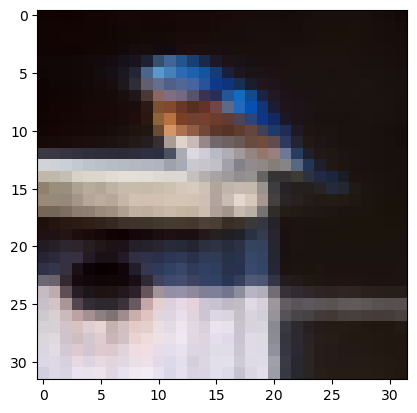

In [5]:
plt.imshow(X_train[13])

By visualizing the sample images to get an idea of the dataset, we can see that the images provided have ultra low resolution, logical enough for being only 32x32 including entire objects. We want to see if that will distort the perfomance of our models enough.

Here we will design a function in order to display after each training the learning curve of the current model

In [6]:
def plot_learning_curve(history):
    # Plot training & validation loss values
    plt.figure(figsize=(7, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Data Preprocessing

### Normalization
As we mentioned before, the input data consists of 32x32 RGB images with pixels' values being in the range of [0, 255]. We normalize this range to be [0, 1], due to the preferance of small input values for faster convergence, equal contribution of each pixel in the mix and for better generalization overall.

In [7]:
# Convert to float32 array for easier management
X_train, X_test = np.array(X_train, dtype=np.float32), np.array(X_test, dtype=np.float32)

#  Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

### Flattening
Each image has 32x32 pixels, with each one having 3 values for each RGB color. To be able to handle this, we will flatten the images into 1-D vector.

In [8]:
X_train, X_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)

### One-Hot Encoding

We choose one-hot encoding on our labels due to the nature of the dataset having categorical output, providing compatibility. Also, cross-entropy loss functions and most of the metrics used like accuracy score or f1 are calculated based on one-hot encoded labels.

In [9]:
Y_train, Y_test = tf.keras.utils.to_categorical(Y_train, num_classes), tf.keras.utils.to_categorical(Y_test, num_classes)

# Basic Model and Feature Engineering

## Finding the most suitable feature engineering techniques for our base MLP model

First of all, we will create and train a simple MLP model to fit our dataset. This model will be used as a base model upon which all other models we will build and are going to be compared to.

More specifically, this model will have one hidden layer with *256 neurons with ReLu activation* and an output layer of *10 neurons with softmax activation*(one for each label). The default settings of Keras fit function are used here for simplicity. The model is trained for **20** epochs using minibatches of **256** samples.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 789258 (3.01 MB)
Trainable params: 789258 (3.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 36.420727014541626s

Train Loss: 1.4373316764831543, Train Accuracy: 0.4963200092315674
Test Loss: 1.5080398321151733, Test Accuracy: 0.46320000290870667


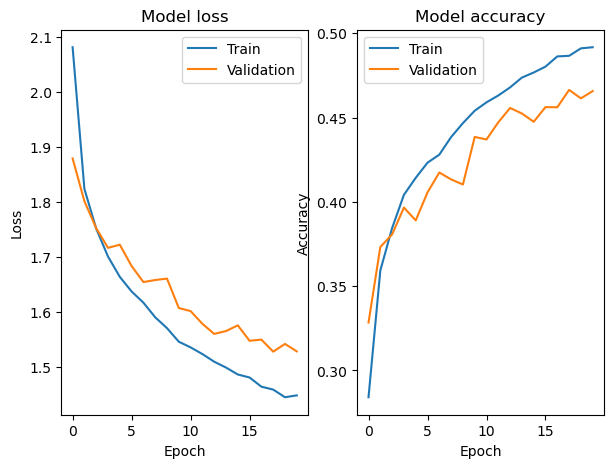

In [10]:
base_model = models.Sequential()

# Adding layers
base_model.add(layers.Dense(256, input_shape=(X_train[1].shape), activation='relu'))
base_model.add(layers.Dense(10, activation='softmax'))

base_model.summary()

base_model.compile(optimizer='adam', # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = base_model.fit(X_train, Y_train, epochs=20, batch_size=256, verbose=0, validation_split=0.2)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = base_model.evaluate(X_train, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = base_model.evaluate(X_test, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

We see that the accuracy on validation set and test set are quite similar and around **45%**, marking a mediocre perfomarnce for the input data without any feature engineering.

Let's start by implementing such methods in the features.

We also want to test the perfomance of this base model on black and white images instead of RGB ones. The significance of this selection lies upon the thought that the color could be neglected from being a factor determining the nature of the depicted model.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 264970 (1.01 MB)
Trainable params: 264970 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 20.565863132476807s

Train Loss: 1.5884740352630615, Train Accuracy: 0.44642001390457153
Test Loss: 1.6846970319747925, Test Accuracy: 0.4059999883174896


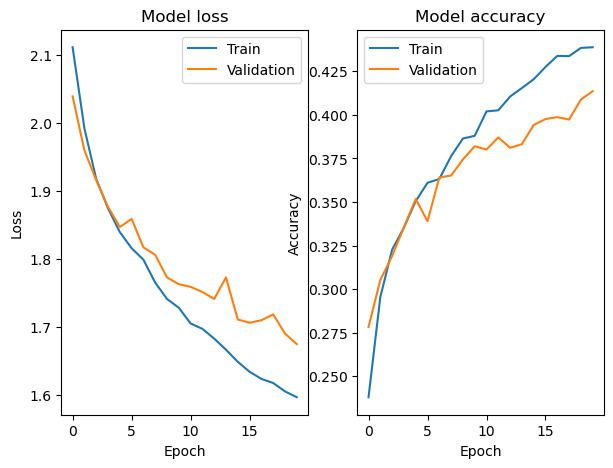

In [11]:
# Converting the RGB input data into BW
from PIL import Image
X_train_bw = np.array([np.array(Image.fromarray(image).convert('L')) for image in X_train_un])
X_test_bw = np.array([np.array(Image.fromarray(image).convert('L')) for image in X_test_un])
X_train_bw, X_test_bw = X_train_bw / 255.0, X_test_bw / 255.0
X_train_bw, X_test_bw = X_train_bw.reshape(X_train_bw.shape[0], -1), X_test_bw.reshape(X_test_bw.shape[0], -1)

# Let's test that thought
base_model = models.Sequential()

# Adding layers
base_model.add(layers.Dense(256, input_shape=(X_train_bw[1].shape), activation='relu'))
base_model.add(layers.Dense(10, activation='softmax'))

base_model.summary()

base_model.compile(optimizer='adam', # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = base_model.fit(X_train_bw, Y_train, epochs=20, batch_size=256, verbose=0, validation_split=0.2)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = base_model.evaluate(X_train_bw, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = base_model.evaluate(X_test_bw, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

The perfomance on this input data is worse than on the original one, meaning that this approach isn't desirable. We will continue using the unattached dataset.

### Feature Engineering Technique 1: Feature Selection
The reason to do this is because sometimes some features are strongly correlated with one another and having both of them provides no additional useful information for the model to learn.

Using a criterion (such as information gain, chi square test or other statistical criteria) we can eliminate the redundant features and keep only the important ones. In this case, we use the chi square test and keep only a percentage of the features with the best scores.

We extract 2457 feautures from the original 3072.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               629248    
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 631818 (2.41 MB)
Trainable params: 631818 (2.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 33.936177492141724s

Train Loss: 1.438729166984558, Train Accuracy: 0.4954800009727478
Test Loss: 1.5148069858551025, Test Accuracy: 0.4652999937534332


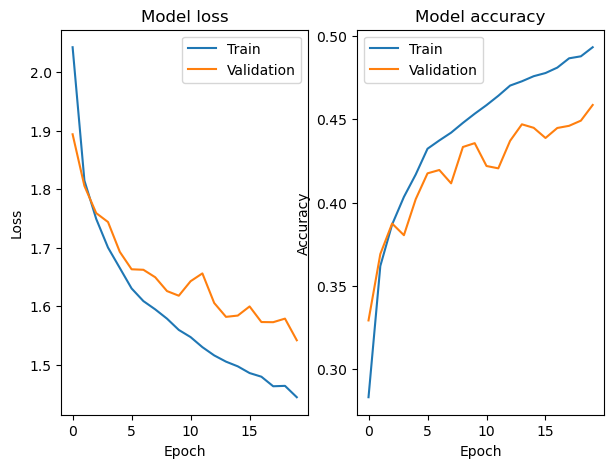

In [12]:
features_perc = SelectPercentile(chi2,percentile=80).fit(X_train, Y_train)
X_train_feat_sel = features_perc.transform(X_train)
X_test_feat_sel = features_perc.transform(X_test)

print("We extract {} feautures from the original {}.".format(X_train_feat_sel.shape[1],X_train.shape[1]))

base_model = models.Sequential()

# Adding layers
base_model.add(layers.Dense(256, input_shape=(X_train_feat_sel[1].shape), activation='relu'))
base_model.add(layers.Dense(10, activation='softmax'))

base_model.summary()

base_model.compile(optimizer='adam', # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = base_model.fit(X_train_feat_sel, Y_train, epochs=20, batch_size=256, verbose=0, validation_split=0.2)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = base_model.evaluate(X_train_feat_sel, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = base_model.evaluate(X_test_feat_sel, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

### Feature Engineering Technique 2: Feature Extraction

Here, PCA is used to reduce the number of features (dimensions) in the dataset while retaining as much variance as possible. It transforms the original data into a new set of uncorrelated variables called principal components. We choose as components's percentage the value **0.9**

We extract 99 feautures from the original 3072.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               25600     
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                                 
Total params: 28170 (110.04 KB)
Trainable params: 28170 (110.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 9.987505912780762s

Train Loss: 1.0064626932144165, Train Accuracy: 0.6596800088882446
Test Loss: 1.355851411819458, Test Accuracy: 0.535099983215332


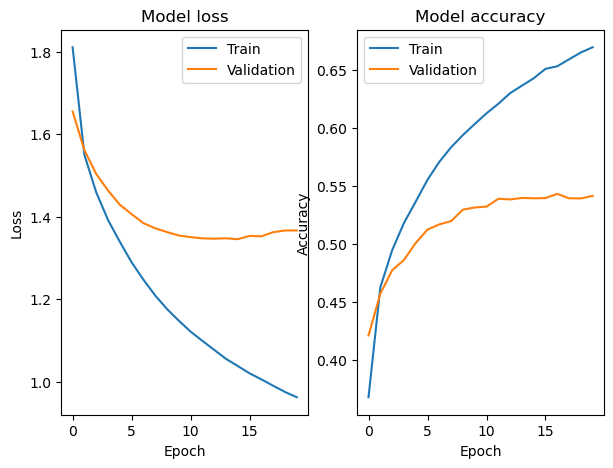

In [13]:
pca = PCA(n_components=0.9).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("We extract {} feautures from the original {}.".format(X_train_pca.shape[1],X_train.shape[1]))

base_model = models.Sequential()

# Adding layers
base_model.add(layers.Dense(256, input_shape=(X_train_pca[1].shape), activation='relu'))
base_model.add(layers.Dense(10, activation='softmax'))

base_model.summary()

base_model.compile(optimizer='adam', # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = base_model.fit(X_train_pca, Y_train, epochs=20, batch_size=256, verbose=0, validation_split=0.2)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = base_model.evaluate(X_train_pca, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = base_model.evaluate(X_test_pca, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

We conclude that **feature extraction** performs better than the **feature selection**, having 10% higher accuracy on each train, validation and test set. So, we will continue by selecting **PCA** as standard.

We also see that after 10 epochs, both the accuracy and the loss on the validation set converge into a constant. This can be happening due to the nature of the dataset or of the PCA's method.

### Feature Engineering Technique 3: Data Scaling

Using StandardScaler, we make the data scale-free by converting its statistical distribution into a format with zero mean and unit variance. This can help prevent a biased outcome of predictions in terms of misclassification error and accuracy rates.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               25600     
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 28170 (110.04 KB)
Trainable params: 28170 (110.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 8.155503273010254s

Train Loss: 0.9401357769966125, Train Accuracy: 0.6859999895095825
Test Loss: 1.4216324090957642, Test Accuracy: 0.5213000178337097


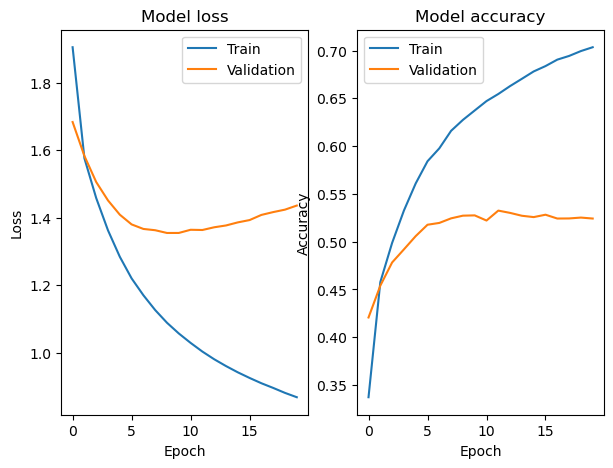

In [14]:
scaler = StandardScaler()
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

base_model = models.Sequential()

# Adding layers
base_model.add(layers.Dense(256, input_shape=(X_train_pca_scaled[1].shape), activation='relu'))
base_model.add(layers.Dense(10, activation='softmax'))

base_model.summary()

base_model.compile(optimizer='adam', # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = base_model.fit(X_train_pca_scaled, Y_train, epochs=20, batch_size=256, verbose=0, validation_split = 0.2)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = base_model.evaluate(X_train_pca_scaled, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = base_model.evaluate(X_test_pca_scaled, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

From the above experiments, we conclude that the best outcome for our base model comes from using **Normalization, PCA for dimensionality reduction and One hot Encoding on the labels**, since PCA with StandardScaler performs pretty much the same. Upon these configurations for the data preprocessing we shall continue our research.


## kNN and Nearest Centroid Classifiers for comparison
For the sake of comparison, we will fit some simple models to our dataset using the kNN and the Nearest Centroid algorithms. We have already occupied ourselves with these three models in the *Intermediate Project*, where we find the most suitable feature engineering methods for each model, so we will fast-forward this section. The comparison will be upon the test set.

### 1-Nearest Neighbors Classifier
The simplest kNN Classifier, getting 100% accuracy on the train set due to overfitting. The highest accuracy on the test set is being accomplished using One-hot Encoding on the labels and PCA.

In [15]:
# Number of nearest neighbors
k = 1

# Initialize the K-Nearest Neighbors classifier
knn_1 = KNeighborsClassifier(n_neighbors=k)

# Start the timer
start = time.time()

# Train the K-Nearest Neighbors model on the training data
knn_1.fit(X_train_pca, Y_train)

# Stop the timer
end = time.time()

print("Training time: {}s\n".format(end-start))

start = time.time()

# Make predictions on the test data
Y_pred = knn_1.predict(X_test_pca)

end = time.time()

print("Testing time: {}s\n".format(end-start))

# Calculate and store the accuracy of the model on both train and test set
accuracy_train = accuracy_score(knn_1.predict(X_train_pca), Y_train)
accuracy_test = accuracy_score(Y_pred, Y_test)

print(f'Accuracy on train set: {accuracy_train:.2f}')
print(f'Accuracy on test set: {accuracy_test:.2f}')

Training time: 0.03583574295043945s

Testing time: 0.9247405529022217s

Accuracy on train set: 1.00
Accuracy on test set: 0.39


### 3-Nearest Neighbors Classifier

We increase the number of nearest neighbors from 1 to 3. The highest accuracy on the test set is being accomplished using PCA only.

In [16]:
# Number of nearest neighbors
k = 3

# Initialize the K-Nearest Neighbors classifier
knn_3 = KNeighborsClassifier(n_neighbors=k)

# Start the timer
start = time.time()

# Train the K-Nearest Neighbors model on the training data
knn_3.fit(X_train_pca, Y_train_un.ravel())

# Stop the timer
end = time.time()

print("Training time: {}s\n".format(end-start))

start = time.time()

# Make predictions on the test data
Y_pred = knn_3.predict(X_test_pca)

end = time.time()

print("Testing time: {}s\n".format(end-start))

# Calculate and store the accuracy of the model on both train and test set
accuracy_train = accuracy_score(knn_3.predict(X_train_pca), Y_train_un.ravel())
accuracy_test = accuracy_score(Y_pred, Y_test_un)

print(f'Accuracy on train set: {accuracy_train:.2f}')
print(f'Accuracy on test set: {accuracy_test:.2f}')

Training time: 0.0s

Testing time: 0.7992007732391357s

Accuracy on train set: 0.62
Accuracy on test set: 0.37


We can see that by increasing the number of neighbors, the increase on the performance of the model is not certain.

### Nearest Centroid Classifier
For this classifier the best feature engineering path was using PCA and StandarScaler at the same time.

In [17]:
# Initialize the Nearest Centroid classifier
ncc = NearestCentroid()

# Start the timer
start = time.time()

# Train the Nearest Centroid model on the training data
ncc.fit(X_train_pca_scaled, Y_train_un.ravel())

# Stop the timer
end = time.time()

print("Training time: {}s\n".format(end-start))

start = time.time()

# Make predictions on the test data
Y_pred = ncc.predict(X_test_pca_scaled)

end = time.time()

print("Testing time: {}s\n".format(end-start))

# Calculate and store the accuracy of the model on both train and test set
accuracy_train = accuracy_score(ncc.predict(X_train_pca_scaled), Y_train_un.ravel()) 
accuracy_test = accuracy_score(Y_pred, Y_test_un)

print(f'Accuracy on train set: {accuracy_train:.2f}')
print(f'Accuracy on test set: {accuracy_test:.2f}')

Training time: 0.03303694725036621s

Testing time: 0.061582088470458984s

Accuracy on train set: 0.40
Accuracy on test set: 0.40


### Conclusions

Model, Techniques  | Accuracy Score | Training time | Testing Time
-------------------|------------------|-------|-------
Base NN,1-hot, PCA       | 0.53 | 6.34s  | 0.34s
1-NN, 1-hot, PCA      | 0.39 | 0.03s | 0.659s
3-NN, PCA| 0.37 | 0.01s  | 0.7s
Nearest Centroid, PCA, StandardScaler | 0.40 |0.03s | 0.05s

We can see that the simple classifiers compared to the base sequential NN model, although they have minimum training and evaluation time, their accuracy on the test set is more than 10% less, marking the MLP classifier, which is still in its primal state, more suitable for our dataset. 

Moreover, the evalution time of the Nearest Centroid Classifier is one order of magnitude lower than of the two knn models and also its accuracy surpasses theirs, marking it the best option among the three of them.


# Choosing the most suitable techniques for our dataset

Before the *hyperparameter-tuning*, we want to figure out step by step the techniques which make our base model perform at its best. To do that, we will design multiple models, switching only one point at a time.

We start deeping into this process by adding one extra layer of neurons in our base model, hoping that the added complexity can increase the performance

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               51200     
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 10)                2570      
                                                                 
Total params: 185098 (723.04 KB)
Trainable params: 185098 (723.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 15.511271238327026s

Train Loss: 0.5469151735305786, Train Accuracy: 0.8715400099754333
Test Loss: 1.9608845710754395, Test Accuracy: 0.5329999923706055


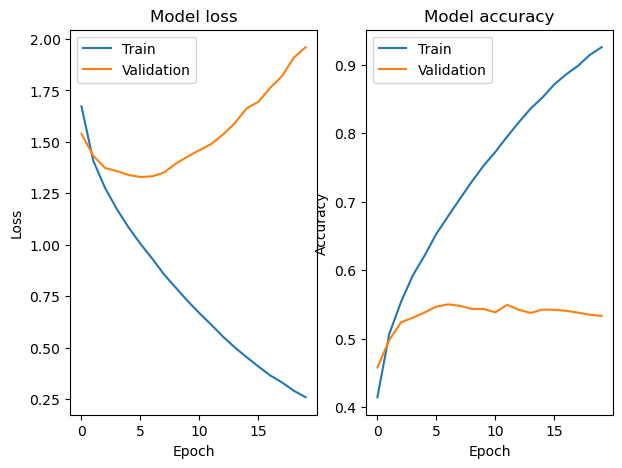

In [18]:
model_1 = models.Sequential()

# Adding layers
model_1.add(layers.Dense(512, input_shape=(X_train_pca[1].shape), activation='relu'))
model_1.add(layers.Dense(256, activation='relu'))
model_1.add(layers.Dense(10, activation='softmax'))

model_1.summary()


model_1.compile(optimizer='Adam', # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = model_1.fit(X_train_pca, Y_train, epochs=20, batch_size=256, validation_split=0.2, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = model_1.evaluate(X_train_pca, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = model_1.evaluate(X_test_pca, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)


Model, Techniques  | Test Accuracy  | Training time
-------------------|------------------|-------
Base NN,1 layer, PCA       | 0.532 | 6.34s
model_1,2 layers, PCA      | 0.534 | 16.018s  

We can see that the increase in the model's accuracy on the test set is near to zero after adding one layer of neurons. On the other hand, the training becomes much slower, increasing the training time to triple of the base model's. Moreover, we can see how fast this model overfits the training data, which makes it doomed from the beginning if any overfitting counter-action doesn't get implemented.

We will choose to move on using the base_model NN architecture with 1 hidden layer, which seems optimal for now. If after implementing our techniques the accuracy remains the same, then we will consider adding more complexity to our model.



## Technique 1: Stochastic Gradient Descent with momentum or without

One way to mitigate overfitting is by implementing SGD on our training instead of the Adam algorithm. We can also use momentum, which helps accelerate the learning process by "remembering" the previous steps that the algorithm made. SGD introduces a certain level of noise into the training process because it uses a random subset of the data (usually one instance) at each step instead of the entire dataset. This stochasticity can help the model escape from local minima and prevent it from fitting too closely to the training data.

Let's see how that model performs

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 256)               25600     
                                                                 
 dense_14 (Dense)            (None, 10)                2570      
                                                                 
Total params: 28170 (110.04 KB)
Trainable params: 28170 (110.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 7.369539499282837s

Train Loss: 1.191288709640503, Train Accuracy: 0.5889999866485596
Test Loss: 1.3561792373657227, Test Accuracy: 0.5236999988555908


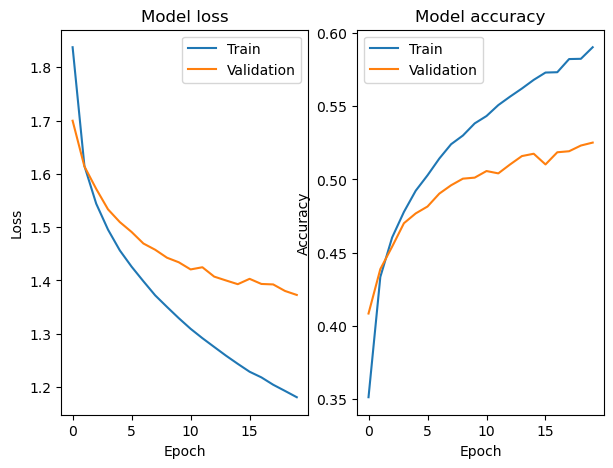

In [19]:
model_2 = models.Sequential()

# Adding layers
model_2.add(layers.Dense(256, input_shape=(X_train_pca[1].shape), activation='relu'))
model_2.add(layers.Dense(10, activation='softmax'))

model_2.summary()

opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_2.compile(optimizer=opt, # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = model_2.fit(X_train_pca, Y_train, epochs=20, batch_size=256, validation_split=0.2, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = model_2.evaluate(X_train_pca, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = model_2.evaluate(X_test_pca, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)


Model, Techniques  | Test Accuracy | Training time
-------------------|------------------|-------
Base NN, PCA, Adam       | 0.532 | 6.34s
Base_NN, PCA, SGD, momentum      | 0.521 |  6.86s  
Base_NN, PCA, SGD, no momentum | 0.45 | 5.59s

We leave the SGD method without momentum out of the discussion from the head start. We see that the Adam optimizer and the SGD with momentum perform pretty much the same. We will continue using the **Adam** and later check if SGD was the real optimal choice.



## Technique 2: Weight Initialization

One typical problem in deep neural networks is that of vanishing or exploding gradients. This causes the weights of the neurons to either become really big or go to zero after training and cause underperformance of the model. This problem is usually caused due to wrong initialization of the weights of the network.

A way to prevent this is by properly initialiazing the weights in a way that the mean of activations is zero and the variance of activations stays the same across the layers. Here, we use the **He Normal** initialization to achieve this. Our decision is based upon the fact that He Normal initialization is suitable for layers where **ReLU** activation function is used.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               25600     
                                                                 
 dense_16 (Dense)            (None, 10)                2570      
                                                                 
Total params: 28170 (110.04 KB)
Trainable params: 28170 (110.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 7.134659051895142s

Train Loss: 1.0636868476867676, Train Accuracy: 0.6351799964904785
Test Loss: 1.3665839433670044, Test Accuracy: 0.5286999940872192


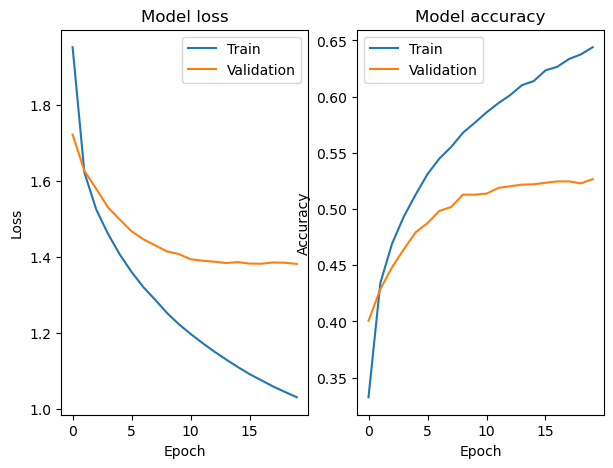

In [20]:
model_3 = models.Sequential()

# Adding layers
model_3.add(layers.Dense(256, input_shape=(X_train_pca[1].shape), activation='relu', kernel_initializer=initializers.HeNormal()))
model_3.add(layers.Dense(10, activation='softmax'))

model_3.summary()

opt = keras.optimizers.Adam(learning_rate=0.001)

model_3.compile(optimizer=opt, # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = model_3.fit(X_train_pca, Y_train, epochs=20, batch_size=256, validation_split=0.2, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = model_3.evaluate(X_train_pca, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = model_3.evaluate(X_test_pca, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)


Model, Techniques  | Test Accuracy | Training time
-------------------|------------------|-------
Base NN, PCA, Adam       | 0.532 | 6.34s
Base_NN, PCA, Adam, He Normal      | 0.528 |  7.5s  

We can see that the Weight Initialization using He Normal didn't affect the performance of our model on the validation/test set or the training time . So, we will continue our research using this method to prevent any underperfomance or anomaly due to any wrong initialization occured.



Once again, the training accuracy begins to skyrocket after just 5 epochs while the test accuracy converged in the area of 50%. From that, we can conclude that our sequential nn base model is keen on **overfitting on the training data**. That's why we will orient our further research upon finding techniques to stop this phenomenon, while also trying to minimize the validation loss and maximize its accuracy.

## Overfitting Solution 1:  L1-Regularization of the weights

Regularization of the weights is used to control the model's complexity and avoid overfitting. The idea behind L1 and L2 regularization is to modify the cost function so that bigger weights cause the cost function to get bigger values. Eventually, in L1 regularization some weights will get 0 values meaning that the connection of this neuron is not active. The cost function only increases by a small percentage of the L1 norm of the weights, here we use a factor of a=0.01, which is actually the default value.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 256)               25600     
                                                                 
 dense_18 (Dense)            (None, 10)                2570      
                                                                 
Total params: 28170 (110.04 KB)
Trainable params: 28170 (110.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 18.293014764785767s

Train Loss: 1.7332406044006348, Train Accuracy: 0.45076000690460205
Test Loss: 1.7257239818572998, Test Accuracy: 0.4562000036239624


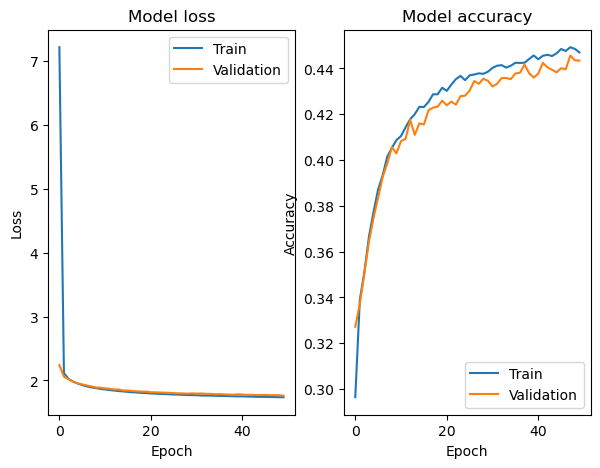

In [21]:
model_4 = models.Sequential()

# Adding layers
model_4.add(layers.Dense(256, input_shape=(X_train_pca[1].shape), activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model_4.add(layers.Dense(10, activation='softmax'))

model_4.summary()

opt = keras.optimizers.Adam(learning_rate=0.001)
model_4.compile(optimizer=opt, # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = model_4.fit(X_train_pca, Y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = model_4.evaluate(X_train_pca, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = model_4.evaluate(X_test_pca, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)


Model, Techniques  | Test Accuracy | Training time
-------------------|------------------|-------
Base NN, PCA, Adam, He Normal       | 0.532 | 6.34s
Base_NN, PCA, Adam, He Normal, l1, epochs=20     | 0.431 |  6.56s  
Base_NN, PCA, Adam, He Normal, l1, epochs=50     | 0.443 |  16.78s

Because we couldn't conclude anything noteworthy at 20 epochs, we increased them to 100 for the next experiment. We come to the conclusion that, even though the L1-regularization successes in keeping the validation and training loss as minimal as possible and avoiding the overfitting, it doesn't produce any worthy results. The underfitting phenomenon with the simultaneous convergence of the accuracies in a constant low value seems rather possible.



## Overfitting Solution 2:  L2-Regularization of the weights

Let's try something similar to model 3 but now the weights are penalized in the cost function using their L2 norm. Again we will use a factor **a=0.01**, which is once again the default configuration.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 256)               25600     
                                                                 
 dense_20 (Dense)            (None, 10)                2570      
                                                                 
Total params: 28170 (110.04 KB)
Trainable params: 28170 (110.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 7.317361831665039s

Train Loss: 1.428881049156189, Train Accuracy: 0.5458999872207642
Test Loss: 1.4902873039245605, Test Accuracy: 0.5199999809265137


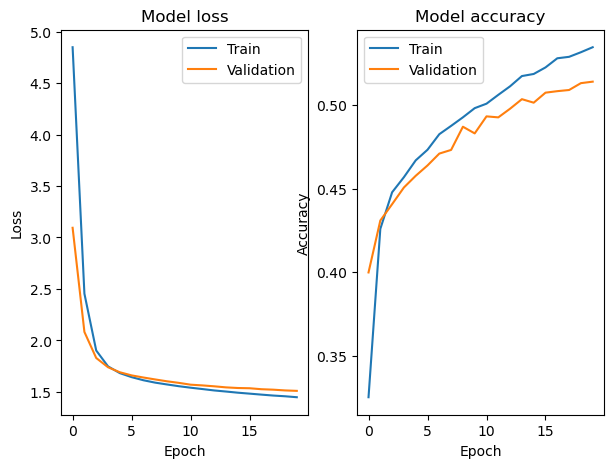

In [22]:
model_5 = models.Sequential()

# Adding layers
model_5.add(layers.Dense(256, input_shape=(X_train_pca[1].shape), activation='relu', kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.HeNormal()))
model_5.add(layers.Dense(10, activation='softmax'))

model_5.summary()

opt = keras.optimizers.Adam(learning_rate=0.001)

model_5.compile(optimizer=opt, # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = model_5.fit(X_train_pca, Y_train, epochs=20, batch_size=256, validation_split=0.2, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = model_5.evaluate(X_train_pca, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = model_5.evaluate(X_test_pca, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

Model, Techniques  | Test Accuracy | Training time
-------------------|------------------|-------
Base NN, PCA, Adam, He Normal       | 0.532 | 6.34s
Base_NN, PCA, Adam, He Normal, l2, epochs=20     | 0.519 |  7.01s  
Base_NN, PCA, Adam, He Normal, l1, epochs=20     | 0.431 |  6.56s 
Base_NN, PCA, Adam, He Normal, l2, epochs=50     | 0.537 |  16.78s
Base_NN, PCA, Adam, He Normal, l1, epochs=50     | 0.458 |  17.34s

We conclude from these experiments that the L2 regularization performs quite better than the L1, producing 10% more accuracy in the same training time. However, both can't reach the accuracy of the model without regularization in the same number of epochs. But, we surely need a regularization method to battle the overfitting occuring as the epochs increase leading to the final evaluation of the ultimate model after the hyperparameter fine-tuning. So, we will choose to procceed with the **L2**.

## Overfitting Solution 3:  Dropout

One of the most common regularization techniques used is that of dropout. The main idea behind dropout is that we train ensembles of models consisting of all subnetworks of the initial network in order to reduce complexity of the model. These subnetworks are formed by removing non-input units from the parent network using a probabilistic rule.

Due to the fact that exponentially many models are created, a practical way to apply dropout is by evaluating a simple model and applying an appropriate weight scaling: the weight of each unit is multiplied by the probability of including that same unit.

In our case we use a probablity p=0.2 of dropping a unit.

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 256)               25600     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 10)                2570      
                                                                 
Total params: 28170 (110.04 KB)
Trainable params: 28170 (110.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training time: 9.305843114852905s

Train Loss: 1.1348198652267456, Train Accuracy: 0.6162999868392944
Test Loss: 1.3061652183532715, Test Accuracy: 0.5386000275611877


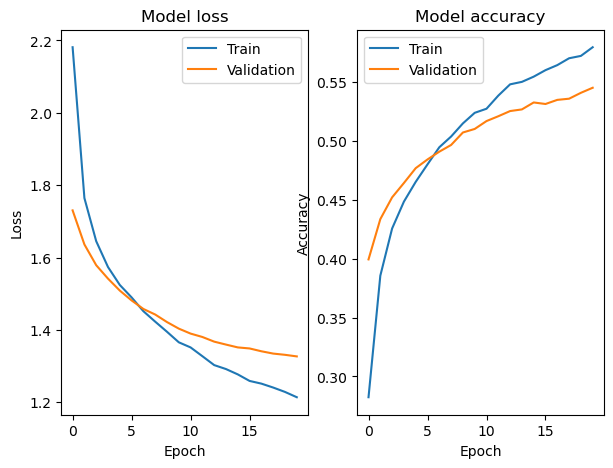

In [23]:
model_6 = models.Sequential()

# Adding layers
model_6.add(layers.Dense(256, input_shape=(X_train_pca[1].shape), activation='relu', kernel_initializer=initializers.HeNormal()))
model_6.add(layers.Dropout(0.2))
model_6.add(layers.Dense(10, activation='softmax'))

model_6.summary()

opt = keras.optimizers.Adam(learning_rate=0.001)
model_6.compile(optimizer=opt, # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = model_6.fit(X_train_pca, Y_train, epochs=20, batch_size=256, validation_split=0.2, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = model_6.evaluate(X_train_pca, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = model_6.evaluate(X_test_pca, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

Model, Techniques  | Test Accuracy | Training time
-------------------|------------------|-------
Base NN, PCA, Adam, He Normal       | 0.532 | 6.34s
Base NN, PCA, Adam, He Normal, Dropout      | 0.544 | 8.81s

We can clearly see that compared to base_model, the overfitting that we have here is smaller since the rate of increase of the cost function in the validation set is much smaller compared to that in base_model.

Regarding the test set, the accuracy we achieve here is a bit higher, meaning that dropout seems like a viable option.

## Overfitting Solution 4:  Early-Stopping

One other common technique used to deal with overfitting is that of early stopping. A reason why models with sufficient capacity overfit is because they are trained for too many epochs causing the validation error to increase over time.

So, the optimal thing to do would be to train the model up to that epoch that we achieve the **minimum loss** function value in the **validation set**.

In this case, we are training the model for 100 epochs instead of 20 without having to worry if they are too many because due to Early Stopping training will stop at the correct epoch. We set patience at 10 meaning that the algorithm will stop after 10 epochs have passed since we have reached a minimum value of the loss function on the validation set.

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               25600     
                                                                 
 dense_24 (Dense)            (None, 10)                2570      
                                                                 
Total params: 28170 (110.04 KB)
Trainable params: 28170 (110.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 27: early stopping
Training time: 8.915484189987183s

Train Loss: 1.0096766948699951, Train Accuracy: 0.6583999991416931
Test Loss: 1.3973661661148071, Test Accuracy: 0.5254999995231628


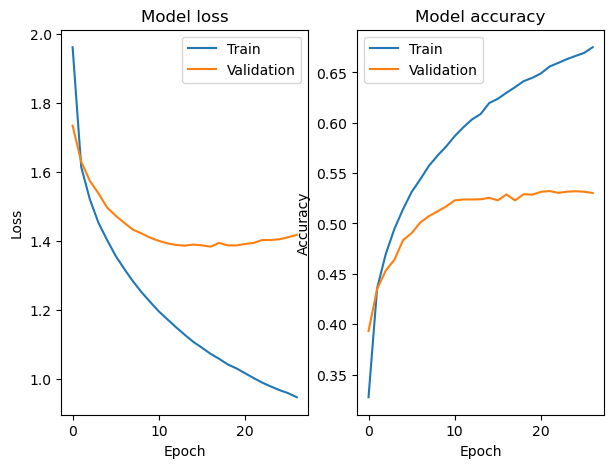

In [24]:
model_7 = models.Sequential()

# Adding layers
model_7.add(layers.Dense(256, input_shape=(X_train_pca[1].shape), activation='relu', kernel_initializer=initializers.HeNormal()))
model_7.add(layers.Dense(10, activation='softmax'))

model_7.summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              mode = 'min',
                                              patience = 10,
                                              verbose=1)

opt = keras.optimizers.Adam(learning_rate=0.001)

model_7.compile(optimizer=opt, # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = model_7.fit(X_train_pca, Y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=0, callbacks=[stop_early])

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = model_7.evaluate(X_train_pca, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = model_7.evaluate(X_test_pca, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

Model, Techniques  | Test Accuracy | Training time
-------------------|------------------|-------
Base NN, PCA, Adam, He Normal       | 0.532 | 6.34s
Base NN, PCA, Adam, He Normal, Early-Stopping, stopped at Epoch= 26     | 0.524 | 8.93s

Even though Early-Stopping didn't produce any significant change in the basic configuration, it can be a tool capable of stopping any training if it decides that there is no point in continuing other than successeding in overfitting on the training data. So, we can experiment on any technique or combinations of them we found useful such as the L2 regularization for plenty of epochs without being concerned if anything goes entirely wrong. So, we shall keep it in mind.

## Overfitting Solution 5:  Batch-Normalization

A common problem in deep neural networks is that due to the fact that all weights are updated simultaneously, there is a high degree of interdependency among parameters across layers causing the model to underperform.

A way to do deal with this is to normalize the activation arguments of the neurons using the mean and variance, which is what batch normalization does.

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 256)               25600     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_26 (Dense)            (None, 10)                2570      
                                                                 
Total params: 29194 (114.04 KB)
Trainable params: 28682 (112.04 KB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________
Training time: 8.039815902709961s

Train Loss: 1.0313645601272583, Train Accuracy: 0.6489599943161011
Test Loss: 1.3756829500198364, Test Accuracy: 0.5281000137329102


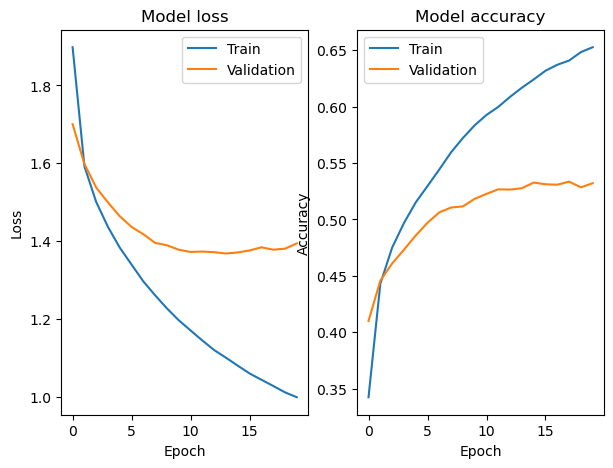

In [25]:
model_8 = models.Sequential()

# Adding layers
model_8.add(layers.Dense(256, input_shape=(X_train_pca[1].shape), activation='relu', kernel_initializer=initializers.HeNormal()))
model_8.add(layers.BatchNormalization())
model_8.add(layers.Dense(10, activation = 'softmax'))

model_8.summary()

opt = keras.optimizers.Adam(learning_rate=0.001)
model_8.compile(optimizer=opt, # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = model_8.fit(X_train_pca, Y_train, epochs=20, batch_size=256, validation_split=0.2, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = model_8.evaluate(X_train_pca, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = model_8.evaluate(X_test_pca, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

Model, Techniques  | Test Accuracy | Training time
-------------------|------------------|-------
Base NN, PCA, Adam, He Normal       | 0.532 | 6.34s
Base NN, PCA, Adam, He Normal, Batch-Normalization     | 0.527 | 7.99s

We can conclude that our model is actually no deep at all and that's why the Batch Normalization didn't produce any noteworthy outcome. If it causes our ultimate model to have larger training time without any increase in the perfomance, we shall not take into consideration any more.

# Hyper-parameter fine-tuning

An important factor and also a challenging problem in Neural Networks is selecting the optimal hyperparameters for the model. Unlike typical parameters such as weights and biases of the model that are learned using algorithms such as Back-Propagation(BK), there aren't similar algorithms to learn hyperparameters, due to the fact that they don't have derivatives, meaning that there is no differential equation to solve for.

A common way to find optimal values for the hyperparameters is by grid search and then cross-validation to the models that occur. Other techniques also include random search or using genetic algorithms.

For our model, the hyperparameters that we want to define :
1.  the number of neurons in the first hidden layer
2. the learning rate of the Adam algorithm
3. the value of the L2 regularization 
4. probability of the dropout for each layer.

 The optimizer that we are going to use is the Hyperband optimizer which is a variation of the Hyperband algorithm (Li, Lisha, and Kevin Jamieson 2018), which reduces significantly the time needed to find the optimal hyperparameters.

In [26]:
%pip install tensorflow-addons

import tensorflow_addons as tfa

%pip install -q -U keras-tuner

import keras_tuner as kt

c:\Users\dmtik\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Note: you may need to restart the kernel to use updated packages.


## Define the hypermodel

- Number of neurons in 1st hidden layer: 256 or 512 or 1024 
- Probability of dropout after each hidden layer: 0.2 or 0.3 or 0.4
- Learning rate of Adam algorithm: 0.01 or 0.001 or 0.0001
- L2 regularization value: 0.01 or 0.001 or 0.0001 or 0.00001

In [49]:
def model_builder(hp):
    model = models.Sequential()

    # Probability p of dropout
    hp_p = hp.Choice('p', values = [0.2, 0.3, 0.4])

    #Number of neurons in the 1st layer is either 256 or 512
    hp_units_1 = hp.Choice('units_1', values = [256, 512, 1024])
    hp_l2 = hp.Choice('l2', values = [1e-2, 1e-3, 1e-4, 1e-5])

    model.add(layers.Dense(units = hp_units_1, input_shape=(X_train_pca[1].shape), activation = 'relu',
                             kernel_initializer = initializers.HeNormal(),  kernel_regularizer=regularizers.l2(hp_l2)))   

    model.add(layers.Dropout(rate=hp_p))

    #Output layer
    model.add(layers.Dense(10, activation = 'softmax'))

    #Learning rate of Adam to be learned by the hypermodel
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-3, 1e-4])

    #Build model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=[tfa.metrics.F1Score(10,'macro'),'accuracy']) #F1 measure is the harmonic mean of recall and precision,
                                                                            #a more robust metric

    return model

## **Find hyperparameters using Hyperband tuner**

Our target is to maximize the accuracy of the model in the validation set. We prefer to solve for maximum validation accuracy instead of minimum validation loss because this procedure will define our ultimate NN model, which we want to perform the best amongst the other options.

In [50]:
#Instantiate tuner
tuner = kt.Hyperband(model_builder,
                      objective = kt.Objective('val_accuracy', direction = 'max'),
                      max_epochs = 100,
                      factor = 3)

Early stopping for safety reasons. It will speed-up the procedure even more and avoid overfitting.

In [51]:
#Early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              mode = 'min',
                                              patience = 10,
                                              verbose=1)

In [52]:
#Search for the optimal hyperparameters
tuner.search(X_train_pca, Y_train, epochs = 100, batch_size=256, validation_split = 0.2, callbacks = [stop_early], verbose = 2)

#Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Optimal number of neurons in 1st layer: {}".format(best_hps.get('units_1')))
print("Optimal value of p for dropout: {}".format(best_hps.get('p')))
print("Optimal value of learning rate: {}".format(best_hps.get('learning_rate')))
print("Optimal value of L2-regularization: {}".format(best_hps.get('l2')))

Trial 70 Complete [00h 00m 06s]
val_accuracy: 0.4571000039577484

Best val_accuracy So Far: 0.4578999876976013
Total elapsed time: 00h 05m 02s
Optimal number of neurons in 1st layer: 1024
Optimal value of p for dropout: 0.3
Optimal value of learning rate: 0.001
Optimal value of L2-regularization: 1e-05


## Build the model with the optimal hyperparameters

We have defined the optimal hyperparameters but now we don't know for how many epochs we should train our model. A simple way to find out is to train the model for many epochs (100 here), define in which one we had the smallest value of the cost function in the validation set and then retrain the model for that number of epochs.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1024)              102400    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                10250     
                                                                 
Total params: 112650 (440.04 KB)
Trainable params: 112650 (440.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training time: 97.39624214172363s



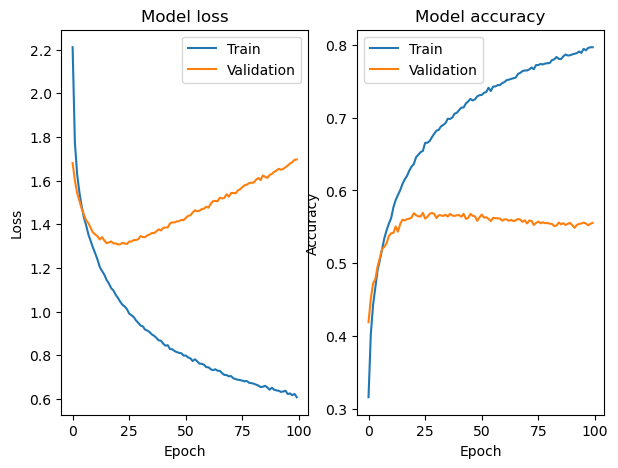

Optimal number of training epochs is: 21


In [53]:

model = models.Sequential()

# Adding layers
model.add(layers.Dense(1024, input_shape=(X_train_pca[1].shape), activation='relu', kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))

model.summary()


opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = model.fit(X_train_pca, Y_train, epochs=100, batch_size=256, validation_split=0.2, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

plot_learning_curve(learning_curve)

val_loss_per_epoch = learning_curve.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print("Optimal number of training epochs is: %d" % (best_epoch,))

## Re-initialize the model and train it with the optimal number of epochs

We now have in our hands the ultimate NN Sequential model with one hidden layer. Let's run it on the test set.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              102400    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 10)                10250     
                                                                 
Total params: 112650 (440.04 KB)
Trainable params: 112650 (440.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training time: 20.163249731063843s

Train Loss: 0.9642395377159119, Train Accuracy: 0.6893399953842163
Test Loss: 1.2900744676589966, Test Accuracy: 0.5597000122070312


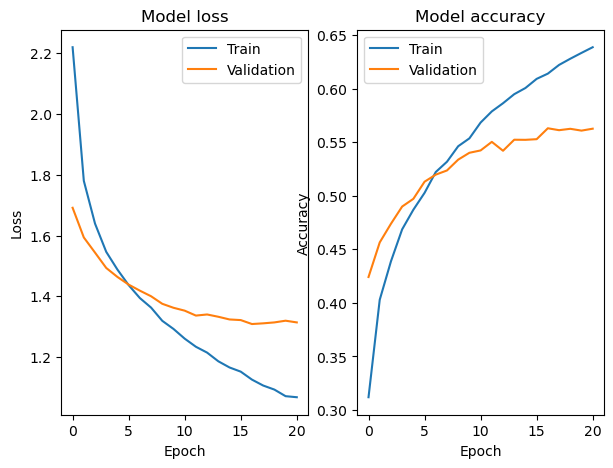

In [54]:
ultimate_model = models.Sequential()

# Adding layers
ultimate_model.add(layers.Dense(1024, input_shape=(X_train_pca[1].shape), activation='relu', kernel_initializer=initializers.HeUniform(), kernel_regularizer=regularizers.l2(0.00001)))
ultimate_model.add(layers.Dropout(0.3))
ultimate_model.add(layers.Dense(10, activation='softmax'))

ultimate_model.summary()


opt = keras.optimizers.Adam(learning_rate=0.001)

ultimate_model.compile(optimizer=opt, # most common optimizer method
              loss='categorical_crossentropy', #not sparse_categorical_crossentropy, since the labels are one-hot-encoded
              metrics=['accuracy']) # common choice for metric

start = time.time()

#Train model
learning_curve = ultimate_model.fit(X_train_pca, Y_train, epochs=21, batch_size=256, validation_split=0.2, verbose=0)

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = ultimate_model.evaluate(X_train_pca, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = ultimate_model.evaluate(X_test_pca, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

## Predict on the test set using the ultimate model

A simple way to evaluate the performance of the model is by displaying its confusion matrix from which we can then extract metrics such the accuracy, precision, recall and F1 measure.

313/313 [==============================] - 0s 811us/step
              precision    recall  f1-score   support

           0       0.63      0.64      0.64      1000
           1       0.71      0.64      0.67      1000
           2       0.43      0.42      0.42      1000
           3       0.41      0.29      0.34      1000
           4       0.47      0.51      0.49      1000
           5       0.47      0.46      0.47      1000
           6       0.57      0.68      0.62      1000
           7       0.66      0.60      0.63      1000
           8       0.63      0.72      0.67      1000
           9       0.59      0.63      0.61      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



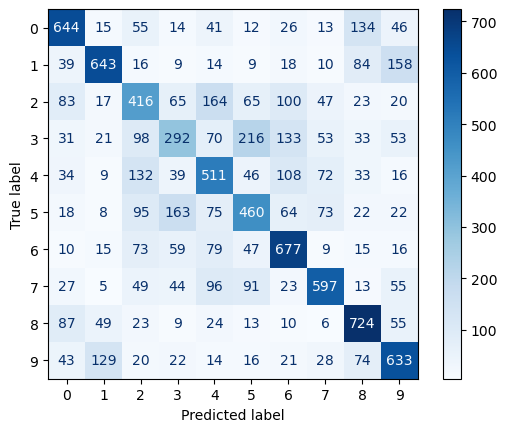

In [55]:
labels = [0,1,2,3,4,5,6,7,8,9]

#Predictions
Y_pred = ultimate_model.predict(X_test_pca, verbose=1)

#Get the value of the predicted label
Y_pred_bool = np.argmax(Y_pred, axis=1)

#Create and display confusion matrix
M = confusion_matrix(Y_test_un, Y_pred_bool)

disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show

#accuracy, precision, recall and f1-score
print(classification_report(Y_test_un, Y_pred_bool))

## Examples of predictions

We will show here some examples of valid and false classification

Printing examples of valid classification:


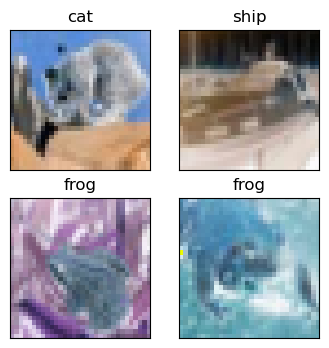

Printing examples of false classification:


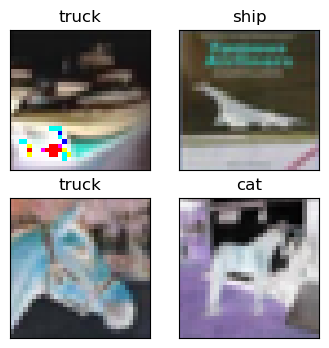

In [56]:
print('Printing examples of valid classification:')
printed = 0
fig = plt.figure(figsize=(4,4))
for i in range (0, Y_test_un.shape[0]):
    if Y_test_un[i] == Y_pred_bool[i]:
        ax = fig.add_subplot(2, 2, printed + 1, xticks=[], yticks=[])
        ax.title.set_text(class_labels[Y_pred_bool[i]])
        ax.imshow((X_test_un[i, :]*255).astype(int))
        printed += 1
    if printed == 4:
        printed = 0
        break
plt.show()
print('Printing examples of false classification:')
fig2 = plt.figure(figsize=(4,4))
for i in range (0, Y_test_un.shape[0]):
    if Y_test_un[i] !=  Y_pred_bool[i]:
        ax2 = fig2.add_subplot(2, 2, printed + 1, xticks=[], yticks=[])
        ax2.title.set_text(class_labels[Y_pred_bool[i]])
        ax2.imshow((X_test_un[i, :]*255).astype(int))
        printed += 1
    if printed == 4:
        break
plt.show()

## Noisy Input

A way to see if our model is able to generalize well is by adding some noise to the images in the test set and see how well it performs.

In this case, we will add some white noise to the images in the test set and check the accuracy of the model 

In [64]:
mean = 0.3
std = 0.1
noise = np.random.normal(mean, std, X_test[0].shape)

X_test_noisy = X_test + noise

print(X_test_noisy.shape)
X_test_noisy_pca = pca.transform(X_test_noisy)


score = ultimate_model.evaluate(X_test_noisy_pca, Y_test)
print('Test accuracy:', score[1])


(10000, 3072)
313/313 [==============================] - 0s 934us/step - loss: 1.7158 - accuracy: 0.4539
Test accuracy: 0.453900009393692


By adding a relatively small amount of noise in the test set, we can see that the predictive ability of the model is reduced. Adding even more noise would cause the accuracy of the model to drop even further.


#  Convolutional Neural Networks (CNNs)

So far, we have examined MLPs with layers that are fully connected. A different architecture is that of CNNs in which the receptive field of each neuron in the convolutional layer is limited to only a region of the input instead of the whole input. The main idea is that the first hidden layers will be able to detect more general characteristics and while we go on to the next layers these will combine so that these layers will detect more specific objects such as a dog or a car for example.

Each layer applies a series of filters to small portions of the image and creates a map of features. Then using what we call a pooling layer we undersample these and repeat this process up until we have only as many features as are our classes. it is also typical that there is one more fully connected layers right before the output layer.

In our case the architecture that we use is inspired by the VGGNet model. More specifically, we have 2 convolutional layers that perform 3x3 convolutions (padding used so that output shape is the same as input shape) followed by a 2x2 max pooling reducing the size of each dimension of the output by a factor of 2. This configuration of 2 convolutional layers followed by a max pooling layer is done for one more time before we add a fully connected hidden layer of 128 neurons. The output layer is a fully connected layer that consists of 10 neurons (1 for each label).

In general, CNNs are considered better at classifying images than typical MLPs. It's time to find out whether our model will also outperform our ultimate sequential model.

## Define the model

Apart from everything else mentioned above about our architecture, we also use batch normalization before each max pooling layer and after the fully connected hidden layer and each convolutional and fully connected layer has its weights initialized using the He Normal initializer. These are because our model is a deep neural network and we want to avoid the problems mentioned in the related sections of part 1.

Moreover, it is worth noticing that most of the trainable variables belong to the fully connected hidden layer. A big advantage of CNNs is that convolutional layers have only a relatably small number of weights due to parameter-sharing. This way we can have many convolutional layers without making the model a lot more complex.

In [67]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation='relu',input_shape=(32,32,3),
                            kernel_initializer=initializers.HeNormal()))

cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation='relu',
                            kernel_initializer=initializers.HeNormal()))

cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.MaxPooling2D(pool_size=(2,2)))

cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu',input_shape=(32,32,3),
                            kernel_initializer=initializers.HeNormal()))

cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu',
                            kernel_initializer=initializers.HeNormal()))

cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.MaxPooling2D(pool_size=(2,2)))

cnn_model.add(layers.Flatten())

cnn_model.add(layers.Dense(1024, activation='relu', kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.00001)))

cnn_model.add(layers.Dense(10))

cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_2 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)       

## Train the CNN model

Due to their architecture, CNNs can be fastly trained by using GPUs. Due to my laptop lack of GPU, we will have to train it using CPU, which will take considerable more time.

For the training process, we are using the Adam algorithm here, too, with learning rate of 0.001. The training is done for 10 epochs. We also used early stopping to avoid overfitting.



Epoch 9: early stopping
Training time: 631.9273643493652s

Train Loss: 0.29128730297088623, Train Accuracy: 0.9427199959754944
Test Loss: 1.3351656198501587, Test Accuracy: 0.7064999938011169


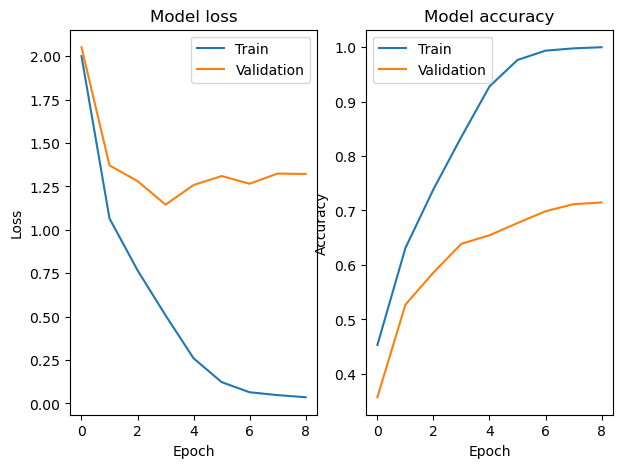

In [68]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])


start = time.time()

# Reshape the flatten input data to their original format as 32x32 RGB color images (x3)
X_train, X_test = X_train.reshape(X_train.shape[0], 32, 32, 3), X_test.reshape(X_test.shape[0], 32, 32, 3)

#Early Stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                              mode = 'min',
                                              patience = 5,
                                              verbose=1)

#Train model
learning_curve = cnn_model.fit(X_train, Y_train, epochs=10, batch_size=256, validation_split=0.2, verbose=0, callbacks=[stop_early])

end = time.time()
print("Training time: {}s\n".format(end-start))

loss_train, accuracy_train = cnn_model.evaluate(X_train, Y_train, verbose = 0)
print(f"Train Loss: {loss_train}, Train Accuracy: {accuracy_train}")

loss_test, accuracy_test = cnn_model.evaluate(X_test, Y_test, verbose = 0)
print(f"Test Loss: {loss_test}, Test Accuracy: {accuracy_test}")

plot_learning_curve(learning_curve)

As we can clearly see, the model outperforms all models that we have tried up until now achieving an accuracy of 0.704. We also notice from the learning curves that the model manages to perfectly fit the training set but without overfitting and losing its ability to generalize, which is why it also performs so well in the validation and test set.


## Noisy Input

We want to test the generalization of the CNN model through adding white noise in the input data, the same way we did it for the ultimate sequential model before.

In [69]:
mean = 0.1
std = 0.1
noise = np.random.normal(mean, std, X_test[0].shape)

X_test_noisy = X_test + noise


score = cnn_model.evaluate(X_test_noisy, Y_test)
print('Test accuracy:', score[1])


313/313 [==============================] - 4s 14ms/step - loss: 2.8365 - accuracy: 0.5136
Test accuracy: 0.5135999917984009


By adding a relatively small amount of noise in the test set, we can see that the predictive ability of the model is reduced. Adding even more noise would cause the accuracy of the model to drop even further.